# A CNN-based approach for OCR

In this project we're going to present a method for letter recognition using Convolutional Neural Network.

It is inspired by this article ["Python Image Recognizer with Convolutional Neural Network"](http://www.codeastar.com/convolutional-neural-network-python/) .

For this project we use EMNIST dataset from ["the EMNIST dataset website"](https://www.nist.gov/itl/iad/image-group/emnist-dataset) .  

Emnist dataset is basically extended dataset contains black-and-white 28x28 pixel formated images of handwritten digits and letters.

## Preprocessing 

Set the path for data source

In [1]:
path = '/home/irza/Projects/gzip/'

### Conversion 


EMNIST dataset contains binary data, so it is still raw, therefore we need to convert it to comply the neural network input.

* Declare the function to convert data form binary to csv
  
  Source : ["MNIST in CSV"](https://pjreddie.com/projects/mnist-in-csv/) . 

In [2]:
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
        
    f.close()
    o.close()
    l.close()    

Convert the binary data to csv

There are already emnist dataset for letters divided into training and test dataset.

Here each data set is converted to csv and saved in file. 

* convert training dataset

In [4]:
convert(path + "emnist-letters-train-images-idx3-ubyte", path + "emnist-letters-train-labels-idx1-ubyte",
        path + "letter_emnist_train.csv", 60000)

* convert test dataset

In [4]:
convert(path + "emnist-letters-test-images-idx3-ubyte", path + "emnist-letters-test-labels-idx1-ubyte",
        path + "letter_emnist_test.csv", 10000)

### Loading the converted dataset

In [5]:
import numpy as np 
import pandas as pd 

df_train = pd.read_csv(path + 'letter_emnist_train.csv', header=None)
df_test = pd.read_csv(path + 'letter_emnist_test.csv', header=None)

### Overview of the data

Here we can see the content of the training and test dataset loaded from csv file and shown as dataframe.

The first column contains the label of the image, the remaining columns contain the pixel values.

In [6]:
df_train.shape

(60000, 785)

In [7]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df_test.shape

(10000, 785)

In [9]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Separate the label column from the pixel columns
 
 Variable name ends with x contains the pixel values.
 
 Variable name ends with y contains the label.

In [10]:
df_train_x = df_train.iloc[:,1:] 
df_train_y = df_train.iloc[:,:1] 

df_test_x = df_test.iloc[:,1:] 
df_test_y = df_test.iloc[:,:1] 

### Overview of class distribution 

* Training set

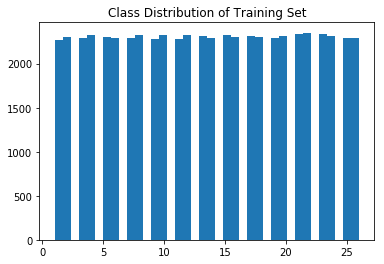

In [11]:
import matplotlib.pyplot as plt

%matplotlib inline
train_y_arr = df_train_y.values.flatten()
plt.hist(train_y_arr, bins='auto')
plt.title("Class Distribution of Training Set")
plt.show()

In [12]:
hist_train, be = np.histogram(train_y_arr, bins='auto')
hist_train = np.delete(hist_train, np.argwhere(hist_train==0))

print("max",hist_train.max())
print("min",hist_train.min())

max 2351
min 2268


* Test set

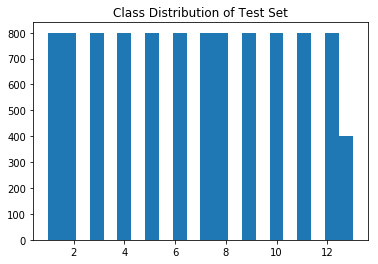

In [13]:
%matplotlib inline
test_y_arr = df_test_y.values.flatten()
plt.hist(test_y_arr, bins='auto')
plt.title("Class Distribution of Test Set")
plt.show()

In [14]:
hist_test, be = np.histogram(test_y_arr, bins='auto')
hist_test = np.delete(hist_test, np.argwhere(hist_test==0))

print("max",hist_test.max())
print("min",hist_test.min())

max 800
min 400


### Overview of the images

Plot some images from training dataset

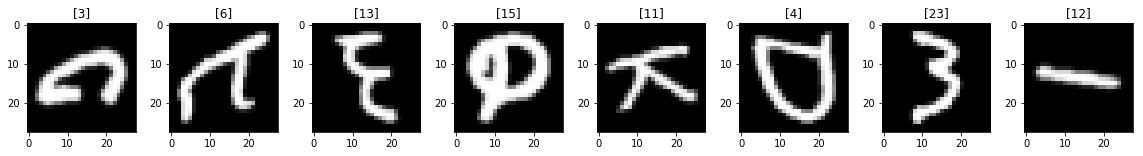

In [12]:
import matplotlib.pyplot as plt

ax = plt.subplots(1,8, figsize=(20,2))
for i in range(0,8):
    j = i+50
    ax[1][i].imshow(df_train_x.values[j].reshape(28,28), cmap='gray')
    ax[1][i].set_title(df_train_y.values[j])

Plot an image for each classs from training dataset.

Some letters might be capital letters, rotated or even mirrored

In [13]:
unique_class = np.unique(df_train_y.iloc[:,0].values)

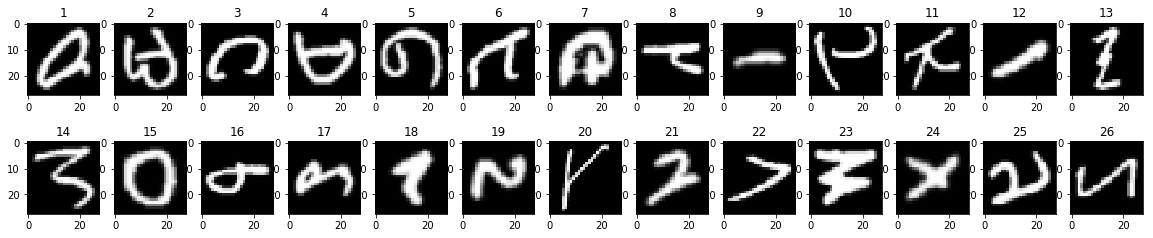

In [14]:
fig, axes = plt.subplots(2,int(len(unique_class)/2), figsize=(20,4))

for i in np.nditer(unique_class):
    pixel_val = df_train.loc[df_train_y.iloc[:,0] == i].iloc[:,1:].head(1).values.reshape(28,28)
    
    row_plot = 0
    col_plot = (i-1) % 13
    
    if i > len(unique_class)/2:
        row_plot = 1
    
    axes[row_plot][col_plot].imshow(pixel_val, cmap='gray')
    axes[row_plot][col_plot].set_title(i)

Plot n image for each class

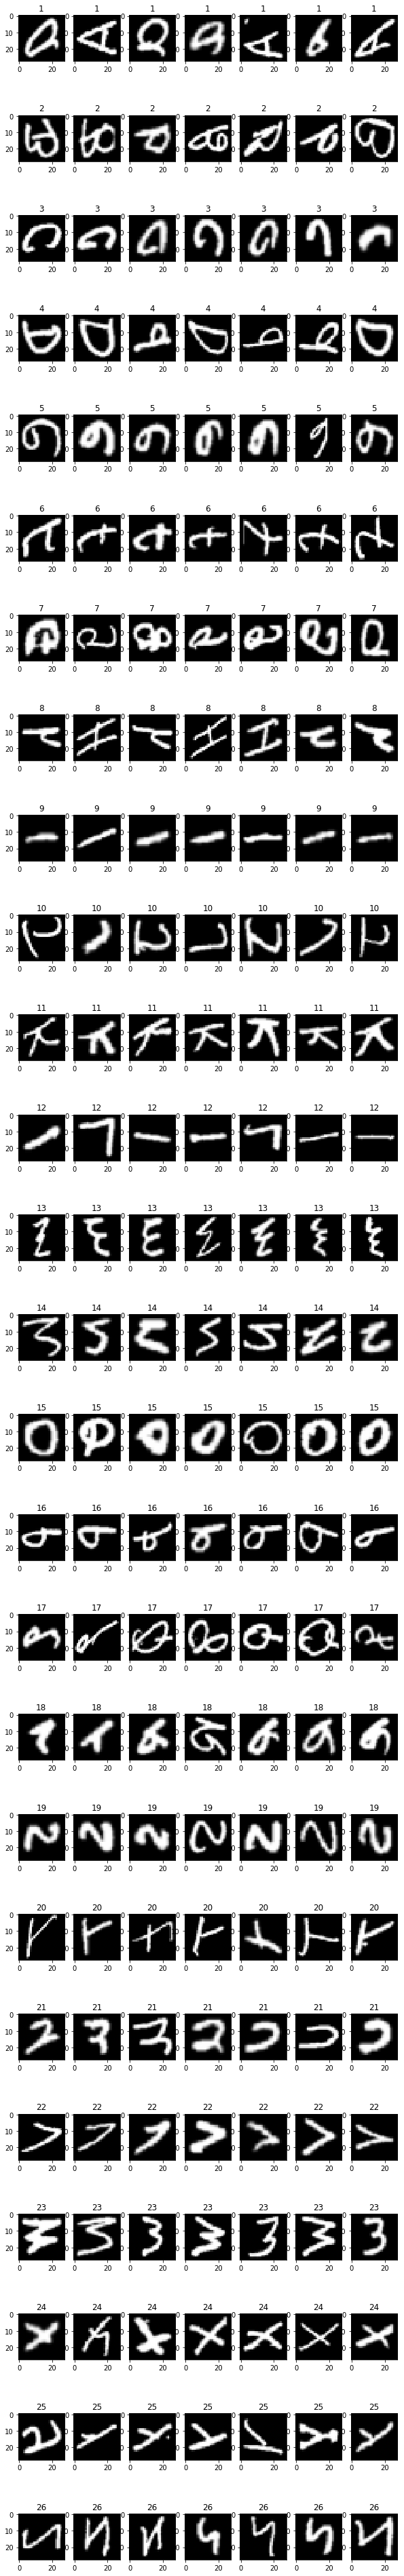

In [15]:
num_sample = 7

fig, axes = plt.subplots(len(unique_class),num_sample, figsize=(10,70))

for i in np.nditer(unique_class):
    pixel_val_arr = df_train.loc[df_train_y.iloc[:,0] == i].iloc[:,1:].head(num_sample).values
    
    for j in range(0,num_sample):
        pixel_val = pixel_val_arr[j].reshape(28,28)
        axes[i-1][j].imshow(pixel_val, cmap='gray')
        axes[i-1][j].set_title(i)

### Normalize images
Images typically have a pixel value range from 0 to 255 (8-bit integer).

We're going to scale them to values between 0 and 1 (floating-point number).

This helps to reduce the computation time.

Then the data will be reshaped.

Reshape training X and text x to (number, height, width, channels)

* rescale the image pixels

In [15]:
df_test_x = df_test_x / 255
df_train_x = df_train_x / 255

* reshape training x and test x into matrix 
  
  the matrix has 4 dimension : 
     
     * number of example
     
     * height
     
     * width 
     
     * number of channel

In [16]:
arr_train_x_28x28 = np.reshape(df_train_x.values, (df_train_x.values.shape[0], 28, 28, 1))
arr_test_x_28x28 = np.reshape(df_test_x.values, (df_test_x.values.shape[0], 28, 28, 1))

In [17]:
print("training set original dimension", df_train_x.values.shape)
print("training set reshaped dimension", arr_train_x_28x28.shape)

training set original dimension (60000, 784)
training set reshaped dimension (60000, 28, 28, 1)


In [18]:
print("test set original dimension", df_test_x.values.shape)
print("test set reshaped dimension", arr_test_x_28x28.shape)

test set original dimension (10000, 784)
test set reshaped dimension (10000, 28, 28, 1)


* turn the label to binary class matrix 

In [19]:
from keras.utils import np_utils

arr_train_y = np_utils.to_categorical(df_train_y.iloc[:,0].values)

/home/irza/anaconda3/envs/deeplearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [20]:
arr_train_y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

* spliting training dataset into training and validation dataset 
  
  validation dataset size = 8%

In [21]:
from sklearn.model_selection import train_test_split

random_seed = 3
split_train_x, split_val_x, split_train_y, split_val_y, = train_test_split(arr_train_x_28x28, arr_train_y, test_size = 0.08, random_state=random_seed)

# Loading the packages

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json

# Building model

The model consists of 

* convolutional layer 1

* max pooling for downsampling

* convolutional layer 2

* dropout layer to set some of the layer's activation to zero, to avoid overfit  

* fully-connected layer

* output layer

Here are the hyperparameter

In [23]:
filter_1_size_w_h = 5
num_of_filter_1 = 32

max_pool_size = 2

filter_2_size_w_h = 3
num_of_filter_2 = 16

dropout_rate = 0.2

dense_1_unit = 130
dense_2_unit = 50

optimizer = 'rmsprop'

In [24]:
def cnn_model(result_class_size):
    
    model = Sequential()
    
    model.add(Conv2D(num_of_filter_1, (filter_1_size_w_h, filter_1_size_w_h), input_shape=(28,28,1), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(max_pool_size, max_pool_size)))
    
    model.add(Conv2D(num_of_filter_2, (filter_2_size_w_h, filter_2_size_w_h), activation='relu'))
    
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    
    model.add(Dense(dense_1_unit, activation='relu'))
    model.add(Dense(dense_2_unit, activation='relu'))
    
    model.add(Dense(result_class_size, activation='softmax'))   
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [25]:
model = cnn_model(arr_train_y.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        4624      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 130)               208130    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                6550      
__________

* Formula to calculate the parameter (param) for any given conv layer :

  params =
( filter_height \* filter_width \* input_image_channels + 1 ) \* number_of_filters

  832 = ( 5 \* 5 \* 1 + 1 ) \* 32


* formula for calculating the output size for any given conv layer :

  output_size = ( ( input_width - filter_width + 2 \* padding ) / stride ) + 1
  
  24 = ( ( 28 - 5 + 2 \* 0 ) / 1 ) + 1
  

# Training configuration and process

* ["ReduceLROnPlateau"](https://keras.io/callbacks/) is set in callback to reduce the learning rate by factor, when the model according to the monitored matrix stops improving after number of epoch set in patience.

* During the training, the images for each epoch will be preprocessed to randomly zoom, rotate, shift them horizontally and vertically. 

  ["ImageDataGenerator"](https://keras.io/preprocessing/image/) 

  ["Keras Image Augmentation API"](https://keras.io/preprocessing/image/)   


In [26]:
#configure output parameter during training
reduce_lr = ReduceLROnPlateau(monitor='val_acc',factor=0.5,patience=3,min_lr=0.00001)

datagen = ImageDataGenerator(
                rotation_range=10,      # randomly rotate images in the range 
                zoom_range = 0.1,       # Randomly zoom image 
                width_shift_range=0.1,  # randomly shift images horizontally
                height_shift_range=0.1  # randomly shift images vertically
            )

datagen.fit(split_train_x)

history = model.fit_generator(
                        datagen.flow(split_train_x,split_train_y, batch_size=64),
                        epochs = 10, validation_data = (split_val_x,split_val_y),
                        verbose = 2, steps_per_epoch=700, 
                        callbacks=[reduce_lr])


Epoch 1/10
 - 77s - loss: 1.2530 - acc: 0.6197 - val_loss: 0.4592 - val_acc: 0.8531
Epoch 2/10
 - 94s - loss: 0.5720 - acc: 0.8198 - val_loss: 0.3462 - val_acc: 0.8860
Epoch 3/10
 - 93s - loss: 0.4443 - acc: 0.8558 - val_loss: 0.2915 - val_acc: 0.9042
Epoch 4/10
 - 93s - loss: 0.3886 - acc: 0.8721 - val_loss: 0.2843 - val_acc: 0.9075
Epoch 5/10
 - 93s - loss: 0.3562 - acc: 0.8836 - val_loss: 0.2570 - val_acc: 0.9144
Epoch 6/10
 - 93s - loss: 0.3311 - acc: 0.8918 - val_loss: 0.2524 - val_acc: 0.9144
Epoch 7/10
 - 94s - loss: 0.3105 - acc: 0.8974 - val_loss: 0.2207 - val_acc: 0.9244
Epoch 8/10
 - 92s - loss: 0.2981 - acc: 0.9013 - val_loss: 0.2314 - val_acc: 0.9223
Epoch 9/10
 - 92s - loss: 0.2870 - acc: 0.9070 - val_loss: 0.3661 - val_acc: 0.8827
Epoch 10/10
 - 92s - loss: 0.2798 - acc: 0.9065 - val_loss: 0.2634 - val_acc: 0.9146


* plot accuracy

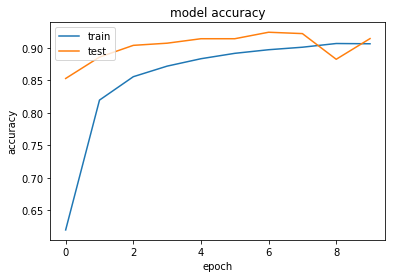

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.savefig('acc.jpg',dpi = 200)
#plt.clf()

* plot loss against epoch

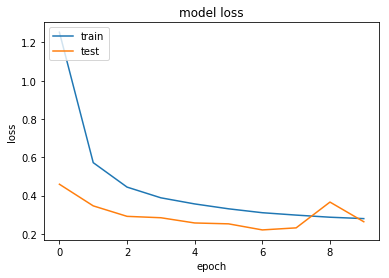

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.savefig('loss.jpg', dpi = 200)
#plt.clf()

# Predicting on test dataset

We're going to use our trained network to make predictions on the test dataset.

The result, our predictions, will be saved as a csv-file. The files consists of the two columns ID and prediction.

In [50]:
prediction = model.predict_classes(arr_test_x_28x28, verbose=0)
data_to_submit = pd.DataFrame({"ImageId": list(range(1,len(prediction)+1)), "Label": prediction})
data_to_submit.to_csv(path + "result.csv", header=True, index = False)

# Show prediction result

We'd now like to show some of the predictions.

Are you able to label them correctly?

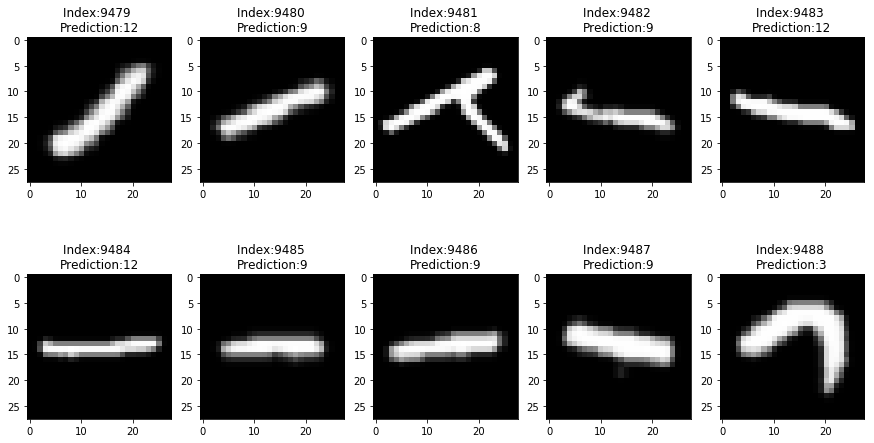

In [30]:
from random import randrange

#pick 10 images from testing data set
start_idx = randrange(df_test_x.shape[0]-10) 


fig, ax = plt.subplots(2,5, figsize=(15,8))
for j in range(0,2): 
  for i in range(0,5):
     ax[j][i].imshow(df_test_x.values[start_idx].reshape(28,28), cmap='gray')
     ax[j][i].set_title("Index:{} \nPrediction:{}".format(start_idx, prediction[start_idx]))
     start_idx +=1

# Confusion matrix for evaluation

To get a metric or let's say a numeric value in order to evaluate how good our network has performed, we're going to calculate the confusion matrix.

The confusion matrix tells us how many predictions were correct. In addition, we also know which classes(letters) were predicted instead.

In [51]:
#http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
   
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(df_test_y,data_to_submit.iloc[:,1])
np.savetxt(path + "cm.csv",conf,delimiter=",",fmt="%10i")

#calculated accuracy from cm
np.round(np.trace(conf) / len(df_test_y),5)

0.8975

* plot the confusion matrix

In [33]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

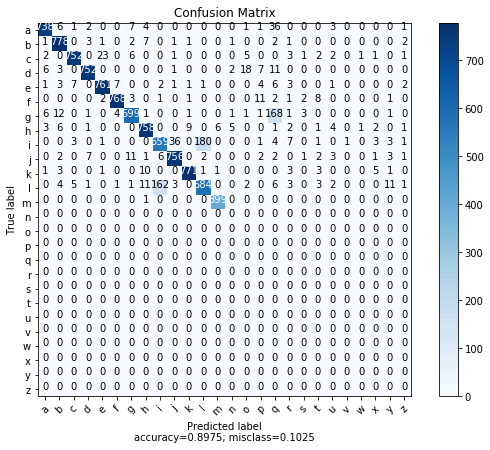

In [35]:
import string

plot_confusion_matrix(cm           = conf, 
                      normalize    = False,
                      target_names = list(string.ascii_lowercase),
                      title        = "Confusion Matrix")

From the confusion matrix diagram, one can see that the letter __i__ is most confused with letter __l__ and visca versa. The same case also happens to the letter __g__ with letter __q__ . This finding is stated as well in the research paper ["EMNIST: an extention of MNIST handwritten letters"](https://arxiv.org/pdf/1702.05373.pdf) . 

# Save and load weights to JSON-file

To save our trained model we're going to save the weights as a JSON-file.

Once our network performs well and we saved our weights, we no longer need to train, configure or evaluate our network.

We can now use this black-box to make new predictions in a few seconds.

In [36]:
#serialize model to JSON
model_json = model.to_json()
with open(path + "model.json", "w") as json_file:
    json_file.write(model_json)

#serialize weights to HDF5
model.save_weights(path + "model.h5")
print("Saved model to disk")

# load json and create model
json_file = open(path + 'model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights(path + "model.h5")
print("Loaded model from disk")

#turn the label to binary class matrix
arr_test_y = np_utils.to_categorical(df_test_y.iloc[:,0].values,27)

# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
score = loaded_model.evaluate(arr_test_x_28x28, arr_test_y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Saved model to disk
Loaded model from disk
acc: 89.75%


The code below is only test, that the training process outputs the model from the last epoch 

In [58]:
prediction = model.predict_classes(split_val_x, verbose=0)
data_to_submit = pd.DataFrame({"ImageId": list(range(1,len(prediction)+1)), "Label": prediction})
data_to_submit.to_csv(path + "result-val.csv", header=True, index = False)

df_pred_y = pd.DataFrame(data=split_val_y.argmax(1))
conf = confusion_matrix(df_pred_y,data_to_submit.iloc[:,1])
np.savetxt(path + "cm-val.csv",conf,delimiter=",",fmt="%10i")

#calculated accuracy from cm
np.round(np.trace(conf) / len(df_pred_y),5)

0.91458